In [ ]:
!pip install keras-tuner

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 8.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 160.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 152.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 109.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 92.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 167.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 209.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 136.8 MB/s eta 0:00:00
     ━━━━━

In [ ]:
pip install protobuf==3.20.*

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 91.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.

[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from skimage.draw import polygon
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras
from keras.models import *
from keras.layers import *
from keras import layers
import tensorflow as tf
import os
#import keras_tuner as kt
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd drive/MyDrive/EchoNet-Dynamic/EchoNet-Dynamic

/content/drive/.shortcut-targets-by-id/1bI7fEoNXBdp_eeIGjz3uPx7LaVeQuwhJ/EchoNet-Dynamic/EchoNet-Dynamic


In [ ]:
batch_size = 64
image_size = (224,224,3)
epochs = 10
learning_rate = 1e-4
path = r""
num_classes = 2

In [ ]:
metadata = pd.read_csv(os.path.join(path,"FileList.csv"))
metadata.drop(axis=0,index=np.arange(10025,10030),inplace=True)

In [ ]:
cd Videos/

/home/ubuntu/Videos


In [ ]:
len(glob.glob("*.avi"))

10030

In [ ]:
cd ..

/home/ubuntu


In [ ]:
vols = pd.read_csv("VolumeTracings.csv")

In [ ]:
vols[vols["FileName"] == "0X234005774F4CB5CD"]
metadata[metadata["FileName"] == "0X234005774F4CB5CD"]

,FileName,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames,Split


In [ ]:
def identity_block(input,kernel_size,filters):
    filter1,filter2,filter3 = filters
    bn_axis = 3
    x = Conv2D(filters=filter1,kernel_size=(1,1),data_format="channels_last")(input)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation("relu")(x)

    x = Conv2D(filters=filter2,kernel_size=kernel_size,padding="same",data_format="channels_last")(x)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation("relu")(x)

    x = Conv2D(filters=filter3,kernel_size=(1,1),data_format="channels_last")(x)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation("relu")(x)

    x = layers.add([x,input])
    x = Activation("relu")(x)

    return x

In [ ]:
def conv_block(input,kernel_size,filters,strides=(2,2)):
    filter1,filter2,filter3 = filters
    bn_axis = 3
    x = Conv2D(filters=filter1,kernel_size=(1,1),strides=strides,data_format="channels_last")(input)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation("relu")(x)

    x = Conv2D(filters=filter2,kernel_size=kernel_size,padding="same",data_format="channels_last")(x)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation("relu")(x)

    x = Conv2D(filters=filter3,kernel_size=(1,1),data_format="channels_last")(x)
    x = BatchNormalization(axis=bn_axis)(x)

    shortcut = Conv2D(filters=filter3,kernel_size=(1,1),strides=strides,data_format="channels_last")(input)
    shortcut = BatchNormalization(axis=bn_axis)(shortcut)
    x = layers.add([x,shortcut])
    x = Activation("relu")(x)

    return x

In [ ]:
def one_side_pad(x):
    x = ZeroPadding2D((1,1),data_format="channels_last")
    x = Lambda(lambda x: x[:,:-1,:-1,:])(x)
    return x

In [ ]:
def ASPP(input,atrous_rates,out_channels):
    res = []
    dims = input.shape
    x = AveragePooling2D((dims[-3],dims[-2]))(input)
    x = Conv2D(kernel_size=(1,1),filters=out_channels,use_bias=True)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = UpSampling2D((dims[-3]//x.shape[1],dims[-2]//x.shape[2]),interpolation="bilinear")(x)
    res.append(x)
    for dilation in atrous_rates:
        x = ZeroPadding2D(padding=(dilation,dilation))(x)
        x = Conv2D(kernel_size=(3,3),filters=out_channels,dilation_rate=dilation,padding="valid",use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        res.append(x)
    size = x.shape[-3:-1]
    #x = AveragePooling2D(pool_size=(3,3))(x)
    #x = Lambda(lambda x: tf.image.resize(x,size))(x)
    x = Conv2D(kernel_size=(1,1),filters=out_channels,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    res.append(x)
    x = Add()(res)
    x = Conv2D(kernel_size=(1,1),filters=out_channels,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(rate=0.5)(x)
    return x

In [ ]:
def deeplab_head(input,num_classes):
    x = ASPP(input,[12,24,36],256)
    x = Conv2D(256,(3,3),padding="same",use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = UpSampling2D((224//x.shape[1],224//x.shape[2]),interpolation="bilinear")(x)
    x = Conv2D(num_classes,(1,1),padding="same")(x)
    return x

In [ ]:
def FCN_head(input,in_channels,out_channels):
    inter_channels = in_channels//4
    x = Conv2D(inter_channels,(3,3),padding="same",use_bias=False)(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(rate=0.1)(x)
    x = Conv2D(out_channels,(1,1))(x)
    return x

In [ ]:
def build_deeplab_decoder(input):
    #x = FCN_head(input,1024,num_classes)
    x = deeplab_head(input,num_classes)
    return x

In [ ]:
def build_encoder(input_layer,num):
    input_shape = (224,224)
    layers = []
    input_layer = input_layer
    bn_axis = 3
    x = ZeroPadding2D((3,3),data_format="channels_last")(input_layer)
    x = Conv2D(64,(7,7),(2,2),data_format="channels_last")(x)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation("relu")(x)
    layers.append(x)
    x = MaxPool2D((3,3),(2,2),data_format="channels_last")(x)
    x = conv_block(x,3,(64,64,256),(1,1))
    x = identity_block(x,3,(64,64,256))
    x = identity_block(x,3,(64,64,256))
    layers.append(x)

    x = conv_block(x,3,(128,128,512))
    x = identity_block(x,3,(128,128,512))
    x = identity_block(x,3,(128,128,512))
    x = identity_block(x,3,(128,128,512))
    layers.append(x)

    x = conv_block(x,3,(256,256,1024))
    x = identity_block(x,3,(256,256,1024))
    x = identity_block(x,3,(256,256,1024))
    x = identity_block(x,3,(256,256,1024))
    x = identity_block(x,3,(256,256,1024))
    x = identity_block(x,3,(256,256,1024))
    layers.append(x)

    x = conv_block(x,3,(512,512,2048))
    x = identity_block(x,3,(512,512,2048))
    x = identity_block(x,3,(512,512,2048))
    layers.append(x)

    #x = AveragePooling2D((7,7),data_format="channels_last")(x)
    #model = Model(inputs=input_layer,outputs=x)
    return layers[num]

In [ ]:
def build_decoder(input):
    n_classes = 2
    bn_axis = 3
    x = ZeroPadding2D((1,1),data_format="channels_last")(input)
    x = Conv2D(512,(3,3),padding="valid",data_format="channels_last")(x)
    x = BatchNormalization(axis=bn_axis)(x)
    x = UpSampling2D((2,2),data_format="channels_last")(x)
    x = ZeroPadding2D((1,1),data_format="channels_last")(x)
    x = Conv2D(256,(3,3),padding="valid",data_format="channels_last")(x)
    x = BatchNormalization(axis=bn_axis)(x)
    x = UpSampling2D((2,2),data_format="channels_last")(x)
    x = ZeroPadding2D((1,1),data_format="channels_last")(x)
    x = Conv2D(128,(3,3),padding="valid",data_format="channels_last")(x)
    x = BatchNormalization(axis=bn_axis)(x)
    x = UpSampling2D((4,4),data_format="channels_last")(x)
    x = ZeroPadding2D((1,1),data_format="channels_last")(x)
    x = Conv2D(64,(3,3),padding="valid",data_format="channels_last")(x)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Conv2D(n_classes,(3,3),padding="same",data_format="channels_last")(x)
    #model = Model(inputs=input,outputs=x)
    return x

In [ ]:
import keras.backend as K

def get_intersection_and_sums(prediction,target):
    p = tf.cast(K.batch_flatten(prediction),tf.float32)
    t = tf.cast(K.batch_flatten(K.argmax(target,axis=-1)),tf.float32)
    print(p.shape,t.shape,sep=" ")
    intersection = K.sum(p * t,axis=-1)
    output_sum = K.sum(p,axis=-1)
    target_sum = K.sum(t,axis=-1)
    return intersection, output_sum, target_sum

In [ ]:
def dice_coef(prediction, target):
    intersection, output_sum, target_sum = get_intersection_and_sums(prediction, target)
    dice = 2 * intersection / (output_sum + target_sum)
    return dice

In [ ]:
def dice_coef1(y_true, y_pred, smooth=1):
    y_true_f = K.batch_flatten(y_true)
    y_pred_f = K.batch_flatten(y_pred)
    y_pred_f = K.argmax(y_pred_f,axis=-1)
    y_pred_f = tf.cast(y_pred_f,tf.float32)
    print(y_true_f.shape,y_pred_f.shape,sep=" ")
    intersection = K.sum(y_true_f * y_pred_f, axis=-1)
    sums = K.sum(y_true_f, axis=-1) + K.sum(y_pred_f, axis=-1)
    return (2. * intersection + smooth) / (sums + smooth)

In [ ]:
def build_network():
    input_layer = Input(shape=(224,224,3))
    output = build_encoder(input_layer,1)
    #output = build_decoder(output)
    output = build_deeplab_decoder(output)
    model = Model(inputs=input_layer,outputs=output)
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3,epsilon=1e-8),metrics=["accuracy",dice_coef])
    return model

In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input,hp):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    dilation_rate = hp.Int("dilation_rate",min_value=2,max_value=12)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=dilation_rate)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=dilation_rate*2)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=dilation_rate*3)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [ ]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    #trainable_layers = hp.Int("trainable_layers"
    for layer in resnet50.layers:
        layer.trainable = True
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)

In [ ]:
def DeeplabV3Plus1(hp):
    image_size = 224
    num_classes = 2
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    trainable_layers = hp.Int("trainable_layers",min_value=0,max_value=len(resnet50.layers))
    for idx,layer in enumerate(reversed(resnet50.layers)):
        if idx == trainable_layers:
            break
        layer.trainable = True
    x = resnet50.get_layer("conv3_block3_2_relu").output
    x = DilatedSpatialPyramidPooling(x,hp)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    model = keras.Model(inputs=model_input, outputs=model_output)
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,epsilon=1e-8),metrics=["accuracy",dice_coef])
    return model

In [ ]:
def load_avi(path, max_frames=0):
    capture = cv2.VideoCapture("Videos/" + path + ".avi")
    frames = []
    try:
        while True:
            ret, frame = capture.read()
            if not ret:
                break
            frame = frame[:,:,[2,1,0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        capture.release()
    for i in range(len(frames)):
        frame = frames[i]
        frames[i] = cv2.resize(frame,dsize=image_size[:2],interpolation=cv2.INTER_CUBIC)
    return np.array(frames) / 255.

In [ ]:
def sequentialize(frame):
    coords1 = frame[["X1","Y1"]].values
    coords2 = np.flip(frame[["X2","Y2"]].iloc[1:].values,axis=0)
    bottom_coord = frame[["X2","Y2"]].iloc[0].values
    coords = np.vstack([coords1,bottom_coord,coords2])
    return coords

In [ ]:
def yield_segmentation(filename):
    frame = vols.loc[(vols["FileName"] == filename + ".avi"),:]
    try:
        mask = frame["Frame"] == frame["Frame"].iloc[0]
    except:
        print(frame,filename)
    first = frame[mask]
    num1 = first["Frame"].iloc[0]
    second = frame[~mask]
    num2 = second["Frame"].iloc[0]
    coords_first = sequentialize(first)
    coords_second = sequentialize(second)
    r1,c1 = polygon(coords_first[:,1],coords_first[:,0])
    r1,c1 = np.clip(r1,0,111),np.clip(c1,0,111)
    r2,c2 = polygon(coords_second[:,1],coords_second[:,0])
    r2,c2 = np.clip(r2,0,111),np.clip(c2,0,111)
    seg1 = np.zeros((112,112),dtype=np.uint8)
    seg1[r1,c1] = 1
    seg1 = cv2.resize(seg1,dsize=image_size[:2],interpolation=cv2.INTER_CUBIC)
    seg2 = np.zeros((112,112),dtype=np.uint8)
    seg2[r2,c2] = 1
    seg2 = cv2.resize(seg2,dsize=image_size[:2],interpolation=cv2.INTER_CUBIC)
    video = load_avi(filename)
    return (video[num1],seg1),(video[num2],seg2)

In [ ]:
def prepare_data(df,root_dir):
    video_paths = df["FileName"].values.tolist()
    num_samples = len(df)*2
    image = np.zeros(shape=(num_samples,224,224,3),dtype="float32")
    mask = np.zeros(shape=(num_samples,224,224,1),dtype="float32")
    for idx,video_path in enumerate(video_paths):
        temp_image = np.zeros(shape=(2,224,224,3),dtype="float32")
        temp_mask = np.zeros(shape=(2,224,224,1),dtype="float32")
        x1,x2 = yield_segmentation(video_path)
        temp_image[0,:,:,:] = x1[0]
        temp_mask[0,:,:] = np.expand_dims(x1[1],axis=-1)
        temp_image[1,:,:,:] = x2[0]
        temp_mask[1,:,:] = np.expand_dims(x2[1],axis=-1)
        image[2*idx:(2*idx)+2,] = temp_image
        mask[2*idx:(2*idx)+2,] = temp_mask
    return image,mask

In [ ]:
class PrepareImagesGen(tf.keras.utils.Sequence):
    def __init__(self,df,batch_size):
        self.df = df.copy()
        self.batch_size = batch_size
        self.input_size = image_size
        self.n = len(self.df)

    def on_epoch_end(self):
        pass

    def __getitem__(self,index):
        batches = self.df[(index*self.batch_size):((index+1)*self.batch_size)]
        X,y = prepare_data(batches,path)
        #print(y.shape)
        return X,y

    def __len__(self):
        return self.n//self.batch_size

In [ ]:
train_gen = PrepareImagesGen(metadata.loc[metadata["Split"] == "TRAIN",:],batch_size=batch_size)
val_gen = PrepareImagesGen(metadata.loc[metadata["Split"] == "VAL",:],batch_size=batch_size)
checkpoint = keras.callbacks.ModelCheckpoint(filepath="models/segmenter.{epoch:02d}-{val_loss:.2f}.hdf5",save_weights_only=True,save_best_only=False)
scheduler = tf.keras.callbacks.LearningRateScheduler(tf.keras.optimizers.schedules.CosineDecay(learning_rate,50),verbose=0)
model = kt.BayesianOptimization(DeeplabV3Plus1,objective=kt.Objective("val_dice_coef", direction="max"),max_trials=21,seed=42,directory="models/")
history = model.search(train_gen,epochs=epochs,callbacks=[checkpoint,scheduler],validation_data=val_gen)
besthp = model.get_best_hyperparameters()[0]
print(besthp)

Trial 3 Complete [10h 02m 27s]
val_dice_coef: 0.8940598368644714

Best val_dice_coef So Far: 0.8940598368644714
Total elapsed time: 1d 06h 06m 40s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
96                |156               |trainable_layers
2                 |5                 |dilation_rate

Epoch 1/10
(None, None) (None, None)
(None, None) (None, None)
626/932 [===================>..........] - ETA: 17:46 - loss: 0.0738 - accuracy: 0.9059 - dice_coef: 0.8460

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



932/932 [==============================] - 3591s 4s/step - loss: 0.0317 - accuracy: 0.9111 - dice_coef: 0.9028 - val_loss: 0.0458 - val_accuracy: 0.9129 - val_dice_coef: 0.8878 - lr: 9.7553e-05
Epoch 7/10
932/932 [==============================] - 3589s 4s/step - loss: 0.0298 - accuracy: 0.9112 - dice_coef: 0.9068 - val_loss: 0.0412 - val_accuracy: 0.9098 - val_dice_coef: 0.8804 - lr: 9.6489e-05
Epoch 8/10
932/932 [==============================] - 3590s 4s/step - loss: 0.0279 - accuracy: 0.9113 - dice_coef: 0.9116 - val_loss: 0.0431 - val_accuracy: 0.9049 - val_dice_coef: 0.8884 - lr: 9.5241e-05
Epoch 9/10
266/932 [=======>......................] - ETA: 39:43 - loss: 0.0258 - accuracy: 0.9107 - dice_coef: 0.9183

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



932/932 [==============================] - 4041s 4s/step - loss: 0.0397 - accuracy: 0.9102 - dice_coef: 0.8885 - val_loss: 0.0442 - val_accuracy: 0.9173 - val_dice_coef: 0.8715 - lr: 9.9606e-05
Epoch 4/10
932/932 [==============================] - 4046s 4s/step - loss: 0.0374 - accuracy: 0.9104 - dice_coef: 0.8927 - val_loss: 0.0444 - val_accuracy: 0.9043 - val_dice_coef: 0.8884 - lr: 9.9114e-05
Epoch 5/10
932/932 [==============================] - 4067s 4s/step - loss: 0.0356 - accuracy: 0.9106 - dice_coef: 0.8956 - val_loss: 0.0405 - val_accuracy: 0.9084 - val_dice_coef: 0.8918 - lr: 9.8429e-05
Epoch 6/10
932/932 [==============================] - 4053s 4s/step - loss: 0.0337 - accuracy: 0.9109 - dice_coef: 0.8988 - val_loss: 0.0421 - val_accuracy: 0.9101 - val_dice_coef: 0.8808 - lr: 9.7553e-05
Epoch 7/10
106/932 [==>...........................] - ETA: 55:00 - loss: 0.0317 - accuracy: 0.9131 - dice_coef: 0.8981

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



932/932 [==============================] - 3959s 4s/step - loss: 0.0666 - accuracy: 0.9082 - dice_coef: 0.8513 - val_loss: 0.0956 - val_accuracy: 0.9306 - val_dice_coef: 0.7467 - lr: 1.0000e-04
Epoch 2/10
932/932 [==============================] - 3965s 4s/step - loss: 0.0425 - accuracy: 0.9102 - dice_coef: 0.8839 - val_loss: 0.0433 - val_accuracy: 0.9087 - val_dice_coef: 0.8885 - lr: 9.9901e-05
Epoch 3/10
932/932 [==============================] - 3955s 4s/step - loss: 0.0392 - accuracy: 0.9103 - dice_coef: 0.8895 - val_loss: 0.0439 - val_accuracy: 0.9073 - val_dice_coef: 0.8834 - lr: 9.9606e-05
Epoch 4/10
932/932 [==============================] - 3946s 4s/step - loss: 0.0369 - accuracy: 0.9105 - dice_coef: 0.8930 - val_loss: 0.0417 - val_accuracy: 0.9042 - val_dice_coef: 0.8917 - lr: 9.9114e-05
Epoch 5/10
932/932 [==============================] - 3945s 4s/step - loss: 0.0350 - accuracy: 0.9107 - dice_coef: 0.8959 - val_loss: 0.0441 - val_accuracy: 0.9125 - val_dice_coef: 0.8718 - l

In [ ]:
import h5py

def inspect_hdf5(file_path):
    with h5py.File(file_path, 'r') as file:
        # Print the keys at the root level
        print("Keys at the root level:", list(file.keys()))

        # Print the attributes at the root level
        print("Attributes at the root level:", dict(file.attrs))

        # Recursively print the keys and attributes in the file
        def print_recursive(name, obj):
            print(name)
            for key, val in obj.attrs.items():
                print("    {}: {}".format(key, val))

        file.visititems(print_recursive)

file_path = 'SegModels/segmenter.06-0.04.hdf5'
inspect_hdf5(file_path)

Keys at the root level: ['average_pooling2d', 'batch_normalization', 'batch_normalization_1', 'batch_normalization_2', 'batch_normalization_3', 'batch_normalization_4', 'batch_normalization_5', 'batch_normalization_6', 'batch_normalization_7', 'batch_normalization_8', 'concatenate', 'concatenate_1', 'conv1_bn', 'conv1_conv', 'conv1_pad', 'conv1_relu', 'conv2_block1_0_bn', 'conv2_block1_0_conv', 'conv2_block1_1_bn', 'conv2_block1_1_conv', 'conv2_block1_1_relu', 'conv2_block1_2_bn', 'conv2_block1_2_conv', 'conv2_block1_2_relu', 'conv2_block1_3_bn', 'conv2_block1_3_conv', 'conv2_block1_add', 'conv2_block1_out', 'conv2_block2_1_bn', 'conv2_block2_1_conv', 'conv2_block2_1_relu', 'conv2_block2_2_bn', 'conv2_block2_2_conv', 'conv2_block2_2_relu', 'conv2_block2_3_bn', 'conv2_block2_3_conv', 'conv2_block2_add', 'conv2_block2_out', 'conv2_block3_1_bn', 'conv2_block3_1_conv', 'conv2_block3_1_relu', 'conv2_block3_2_bn', 'conv2_block3_2_conv', 'conv2_block3_2_relu', 'conv2_block3_3_bn', 'conv2_bloc

In [ ]:
import h5py

def explore_hdf5_group(group, indent=0):
    for key, value in group.items():
        print("  " * indent + f"Key: {key}")
        if isinstance(value, h5py.Group):
            explore_hdf5_group(value, indent + 1)
        elif isinstance(value, h5py.Dataset):
            print("  " * (indent + 1) + f"Dataset shape: {value.shape}, type: {value.dtype}")

def explore_hdf5_file(file_path):
    with h5py.File(file_path, 'r') as file:
        print("Root level keys and attributes:")
        explore_hdf5_group(file)

file_path = 'SegModels/segmenter.06-0.04.hdf5'
explore_hdf5_file(file_path)

Root level keys and attributes:
Key: average_pooling2d
Key: batch_normalization
  Key: batch_normalization
    Key: beta:0
      Dataset shape: (256,), type: float32
    Key: gamma:0
      Dataset shape: (256,), type: float32
    Key: moving_mean:0
      Dataset shape: (256,), type: float32
    Key: moving_variance:0
      Dataset shape: (256,), type: float32
Key: batch_normalization_1
  Key: batch_normalization_1
    Key: beta:0
      Dataset shape: (256,), type: float32
    Key: gamma:0
      Dataset shape: (256,), type: float32
    Key: moving_mean:0
      Dataset shape: (256,), type: float32
    Key: moving_variance:0
      Dataset shape: (256,), type: float32
Key: batch_normalization_2
  Key: batch_normalization_2
    Key: beta:0
      Dataset shape: (256,), type: float32
    Key: gamma:0
      Dataset shape: (256,), type: float32
    Key: moving_mean:0
      Dataset shape: (256,), type: float32
    Key: moving_variance:0
      Dataset shape: (256,), type: float32
Key: batch_norma

1/1 [==============================] - 0s 34ms/step


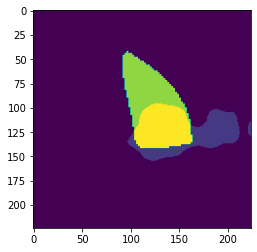

In [ ]:
image = train_gen.__getitem__(0)
p = network_model.predict(image[0])
#plt.imshow(np.argmax(p[0],axis=2))
plt.imshow((image[1][0]*5)+np.argmax(p[0],axis=2,keepdims=True))

In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input, i):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    dilation_rate = i # 2 to 12 possibility

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=dilation_rate)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=dilation_rate*2)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=dilation_rate*3)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output
def DeeplabV3Plus1(i):
    image_size = 224
    num_classes = 2
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = tf.keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    #trainable_layers = hp.Int("trainable_layers",min_value=0,max_value=len(resnet50.layers))
    for idx,layer in enumerate(reversed(resnet50.layers)):
        #if idx == trainable_layers:
            #break
        layer.trainable = True
    x = resnet50.get_layer("conv3_block3_2_relu").output
    x = DilatedSpatialPyramidPooling(x, i)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    model = keras.Model(inputs=model_input, outputs=model_output)
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,epsilon=1e-8),metrics=["accuracy",dice_coef])
    return model

In [ ]:
train_gen = PrepareImagesGen(metadata.loc[metadata["Split"] == "TRAIN",:],batch_size=batch_size)

In [ ]:
images = [train_gen.__getitem__(i) for i in range(4)]

KeyboardInterrupt: ignored

In [ ]:
for i in range(3,7):
  model = DeeplabV3Plus1(i)
  model.load_weights('SegModels/segmenter.06-0.04.hdf5')
  j = 0
  print(i)
  for image in images:
    print(j, model.evaluate(x=image[0],y=image[1]),sep='\n')
    j += 1
  print('------------------')

94765736/94765736 [==============================] - 5s 0us/step
(32, 50176) (32, 50176)
(32, 50176) (32, 50176)
4/4 [==============================] - 9s 27ms/step - loss: 0.0404 - accuracy: 0.9834 - dice_coef: 0.8936
0
[0.04040432721376419, 0.9833646416664124, 0.8936485052108765]
4/4 [==============================] - 0s 25ms/step - loss: 0.0428 - accuracy: 0.9823 - dice_coef: 0.8963
1
[0.04284578189253807, 0.9823237657546997, 0.8963123559951782]
4/4 [==============================] - 0s 25ms/step - loss: 0.0444 - accuracy: 0.9819 - dice_coef: 0.8753
2
[0.044398702681064606, 0.9818532466888428, 0.8752582669258118]
4/4 [==============================] - 0s 25ms/step - loss: 0.0395 - accuracy: 0.9837 - dice_coef: 0.8958
3
[0.039512261748313904, 0.9837148189544678, 0.8958278298377991]
------------------
(32, 50176) (32, 50176)
(32, 50176) (32, 50176)
4/4 [==============================] - 1s 26ms/step - loss: 0.0288 - accuracy: 0.9875 - dice_coef: 0.9120
0
[0.028762757778167725, 0.98752

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm

def save_overlay_as_pdf(image, segmentation, filename):
    # Create a binary mask from the segmentation
    binary_mask = np.argmax(segmentation, axis=-1)

    # Create a color mask with the segmentation in blue, normalized
    color_mask = np.zeros_like(image)
    color_mask[binary_mask == 1] = [0, 0, 1] # Blue color, normalized

    # Overlay the color mask on the original image with 75% opacity
    overlayed_image = cv2.addWeighted(image, 0.25, color_mask, 0.75, 0) # 75% opacity

    # Plot and save as PDF
    #plt.tight_layout()
    plt.imshow(overlayed_image)
    plt.axis('off') # Remove axis
    #plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.0, format='pdf')
    plt.close()



# Assuming you have a test generator or some images loaded
test_gen = PrepareImagesGen(metadata.loc[metadata["Split"] == "TEST",:], batch_size=10)

# Load the model
model = DeeplabV3Plus1(4)
model.load_weights('SegModels/segmenter.06-0.04.hdf5')

# Get a batch of images and segmentations
images, _ = test_gen.__getitem__(0)

# Predict segmentations
segmentations = model.predict(images)

# Overlay segmentations and save as PDFs
for i in tqdm(range(10)):
    save_overlay_as_pdf(images[i], segmentations[i], f'segmentation_{i}.pdf')


1/1 [==============================] - 1s 549ms/step


100%|██████████| 10/10 [00:07<00:00,  1.34it/s]
